In [1]:
from schnetpack import AtomsData, AtomsLoader
from ase.visualize import view
import torch 
import numpy as np
from matplotlib import pyplot as plt
import h5py
from qml.representations import *
import sys
import pandas as pd
import time
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F

2021-11-05 14:45:32.857601: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-05 14:45:32.858363: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [ ]:
def get_unpacked_properties(dizionario,data):
    props_list=data.available_properties
    k=0
    for key in data.available_properties:
        tmp=list(dizionario[key].size())
        if len(tmp)==3 and tmp[1]!=1:
            props_list.remove(key)
            for i in range(0,tmp[1]):
                dizionario[key+'_{}'.format(i)]=dizionario[key][:,i]
                props_list.insert(k,key+'_{}'.format(i))
                k=k+1
            del dizionario[key]
        k=k+1
    return props_list

def normalization(dizionario,props_list):
    for key in props_list:
        tmp_avg=dizionario[key].mean().item()*torch.ones_like(dizionario[key])
        tmp_std=dizionario[key].std().item()*torch.ones_like(dizionario[key])
        dizionario[key]=(dizionario[key]-tmp_avg).div(tmp_std)
    return dizionario
        
        

def data_preparation(data,shuffle=False,normalize=False,save_to_file=True):
    loader=AtomsLoader(data,batch_size=int(data.__len__()),shuffle=shuffle)
    dizionario=next(iter(loader))
    props_list=get_unpacked_properties(dizionario,data)
    print(dizionario)
    if normalize==True:
        dizionario=normalization(dizionario, props_list)
        print(dizionario)
    t=()
    for key in props_list:
        t=t+(dizionario[key],)
    df=pd.DataFrame(torch.cat(t,1).tolist(), columns = props_list)
    df['atom_numbers']=dizionario['_atomic_numbers'].tolist()
    df['positions']=dizionario['_positions'].tolist()
    df['#C']=df['atom_numbers'].apply(lambda x: np.count_nonzero(np.array(x)==6))
    df['#H']=df['atom_numbers'].apply(lambda x: np.count_nonzero(np.array(x)==1))
    df['#N']=df['atom_numbers'].apply(lambda x: np.count_nonzero(np.array(x)==7))
    df['#O']=df['atom_numbers'].apply(lambda x: np.count_nonzero(np.array(x)==8))
    df['#S']=df['atom_numbers'].apply(lambda x: np.count_nonzero(np.array(x)==16))
    df['#Cl']=df['atom_numbers'].apply(lambda x: np.count_nonzero(np.array(x)==17))
    max_asize={'C': df['#C'].max(), 'H': df['#H'].max(), 'N': df['#N'].max(), 'O': df['#O'].max(), 'S': df['#S'].max(),'Cl':df['#Cl'].max()}
    max_size=list(dizionario['_positions'].size())[1]
    df['BoB'] = df['atom_numbers'].combine(df['positions'], lambda x,y: generate_bob(x, y,size=max_size,asize=max_asize))
    #df=df.drop(columns=['atom_numbers','positions','#C','#H','#N','#O','#S','#Cl'])
    props_list.insert(0,'BoB')
    #df=df[props_list]
    #if normalize==True:
    #    for key in props_list:
    #        if key!='BoB':
    #            df[key]=df[key].apply(lambda x: (x-df[key].mean())/(df[key].std()))
    if save_to_file==True:
        df.to_json('./dataframe{}.json'.format(data.__len__()))
    return df

In [2]:
data=AtomsData('./QM7Xfull2_stableconfs.db')
data.__len__()


41537

In [ ]:
setid='1000'
fMOL = h5py.File(setid+'.hdf5', 'r')
mol_ids = list(fMOL.keys())
for molid in mol_ids:
        #stdout.write('Current molecule: '+molid+'\n  Conformations:')
        
        ## get IDs of individual configurations/conformations of molecule
        conf_ids = list(fMOL[molid].keys())
        print(conf_ids,np.size(conf_ids))


In [20]:
file = open("sample.txt", "w")

tmp=4.5

file.write("error torch seed 0" + '{}'.format(tmp))

file.close()

<Figure size 432x288 with 0 Axes>

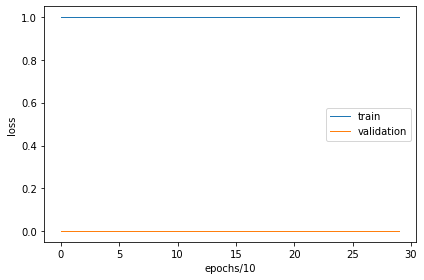

In [17]:
l=1
a=1
plt.figure('fishertot')
fig, ax = plt.subplots()
ax.plot(np.ones(30),linestyle='solid',linewidth=l,label=r'train',alpha=a)
ax.plot(np.zeros(30),linestyle='solid',linewidth=l,label=r'validation',alpha=a)

leg = ax.legend(prop={'size': 10})
text=leg.get_texts()
for i in range(0,len(text)):
    text[i].set_color('black')
plt.xlabel('epochs/10')
plt.ylabel('loss')
plt.tight_layout()
plt.savefig('train_val_vs_epochs.pdf')

In [ ]:
df=data_preparation(data)
df

In [ ]:
max_asize={'C': df['#C'].max(), 'H': df['#H'].max(), 'N': df['#N'].max(), 'O': df['#O'].max(), 'S': df['#S'].max(),'Cl':df['#Cl'].max()}
max_size=list(dizionario['_positions'].size())[1]
print(max_asize)

In [3]:
#data=AtomsData('./QM7Xbis_nonid.db')
df=pd.read_json('./dataframe{}.json'.format(data.__len__()))
df

Eat      EMBD         EPBE0           C6        POL      HLGAP  \
0      19.313757 -0.022546  -1101.471924   105.456398  17.087168  11.647887   
1      40.527245 -0.102043  -3675.476807   636.799133  41.802761   7.115084   
2      55.833977 -0.154351  -5745.968750  1547.620850  66.565659   6.716368   
3      55.732784 -0.165974  -5745.867188  1450.836060  63.615719   6.452832   
4      55.818230 -0.151424  -5745.952637  1574.522705  67.346855   7.083825   
...          ...       ...           ...          ...        ...        ...   
41532  62.640831 -0.231384 -18052.117188  3043.401611  91.866783   5.703696   
41533  62.640835 -0.231390 -18052.117188  3043.162109  91.862564   5.703610   
41534  62.085972 -0.232447 -18051.560547  2952.806641  90.381546   5.188798   
41535  63.169563 -0.224530 -18052.644531  3070.153564  92.302521   5.094806   
41536  69.200958 -0.274211 -18085.958984  3309.679932  95.950600   5.469238   

            DIP    hCHG_0    hCHG_1    hCHG_2  ...  atPOL_22  \
0      0.000006 -0.166435  0.041610  0.041606  ...       0.0   
1      0.255873 -0.116716 -0.025575 -0.237354  ...       0.0   
2      0.301033 -0.104082 -0.042526 -0.007639  ...       0.0   
3      0.301416 -0.105033 -0.037205 -0.008723  ...       0.0   
4      0.338894 -0.105437 -0.038786 -0.008529  ...       0.0   
...         ...       ...       ...       ...  ...       ...   
41532  1.233593 -0.338826  0.091936 -0.101876  ...       0.0   
41533  1.233464 -0.338791  0.091975 -0.101868  ...       0.0   
41534  1.254137 -0.270708  0.096049 -0.092683  ...       0.0   
41535  1.038057 -0.320479  0.104198 -0.094457  ...       0.0   
41536  1.334412 -0.356688  0.097498 -0.104992  ...       0.0   

                                            atom_numbers  \
0      [6, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1      [6, 6, 7, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ...   
2      [6, 6, 6, 6, 7, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...   
3      [6, 6, 6, 6, 7, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...   
4      [6, 6, 6, 6, 7, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...   
...                                                  ...   
41532  [16, 6, 7, 6, 6, 7, 6, 1, 1, 1, 1, 1, 1, 0, 0,...   
41533  [16, 6, 7, 6, 6, 7, 6, 1, 1, 1, 1, 1, 1, 0, 0,...   
41534  [16, 6, 7, 6, 6, 7, 6, 1, 1, 1, 1, 1, 1, 0, 0,...   
41535  [16, 6, 7, 6, 6, 6, 7, 1, 1, 1, 1, 1, 1, 0, 0,...   
41536  [16, 6, 7, 6, 6, 6, 7, 1, 1, 1, 1, 1, 1, 1, 1,...   

                                               positions  #C  #H  #N  #O  #S  \
0      [[4.9637000000000004e-06, -2.3876000000000002e...   1   4   0   0   0   
1      [[-1.201035738, -0.40347486730000004, -0.27543...   2   7   1   0   0   
2      [[0.5095295906, 2.1773529053, -0.0534484275], ...   4   7   1   0   0   
3      [[1.4956327677, 1.0426191092, -0.4607066214], ...   4   7   1   0   0   
4      [[-0.1619589031, -2.0314459801, 0.936764121100...   4   7   1   0   0   
...                                                  ...  ..  ..  ..  ..  ..   
41532  [[-1.9964131117, -2.0348e-06, 1.0504854918], [...   4   6   2   0   1   
41533  [[-1.9543379545000001, 7.30461e-05, 1.12660360...   4   6   2   0   1   
41534  [[-0.3404679298, 0.5000302792, -2.0532391071],...   4   6   2   0   1   
41535  [[-2.2401089668, -0.0240121782, 0.0067041223],...   4   6   2   0   1   
41536  [[-1.8138500452000001, 0.0684815794, 1.3719086...   4   8   2   0   1   

       #Cl                                                BoB  
0        0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1        0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2        0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3        0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4        0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
...    ...                                                ...  
41532    0  [388.0234410267, 0.0, 0.0, 41.1487092201, 41.1...  
41533    0  [388.0234410267, 0.0, 0.0, 41.1494205801, 41.1...  
41534    0  [388.0234410267, 0.0, 0.0

In [35]:
model=nn.Sequential(
          nn.Linear(53,200),
          nn.Tanh(),
          nn.Linear(200,200),
          nn.Tanh(),
          nn.Linear(200,1000),
          nn.Tanh(),
          nn.Linear(1000,528*2),
        )


In [28]:
df=df.sample(frac=1)
dati = torch.Tensor(df['BoB'][0:30000])
vec=list(df.columns[0:7])+list(df.columns[30:53])
labels=df[list(df.columns[0:53])]#df.loc[:, df.columns != 'BoB']
#labels=labels.loc[:, labels.columns != 'atom_numbers']
#labels=labels.loc[:, labels.columns != 'positions']
labels = torch.Tensor(labels.values[0:30000,:])
dataset = TensorDataset(dati,labels)

In [13]:
tmp=list(np.random.randn(4))
print(tmp)
print(np.argmin(tmp))

[-1.4734503921851763, 0.4956961530395145, -1.9713508980742214, -2.4413843575992478]
3


In [11]:
lista=list(df.columns)
lista.remove('atom_numbers')
lista.remove('positions')
lista

['Eat',
 'EMBD',
 'EPBE0',
 'C6',
 'POL',
 'HLGAP',
 'DIP',
 'hCHG_0',
 'hCHG_1',
 'hCHG_2',
 'hCHG_3',
 'hCHG_4',
 'hCHG_5',
 'hCHG_6',
 'hCHG_7',
 'hCHG_8',
 'hCHG_9',
 'hCHG_10',
 'hCHG_11',
 'hCHG_12',
 'hCHG_13',
 'hCHG_14',
 'hCHG_15',
 'hCHG_16',
 'hCHG_17',
 'hCHG_18',
 'hCHG_19',
 'hCHG_20',
 'hCHG_21',
 'hCHG_22',
 'atPOL_0',
 'atPOL_1',
 'atPOL_2',
 'atPOL_3',
 'atPOL_4',
 'atPOL_5',
 'atPOL_6',
 'atPOL_7',
 'atPOL_8',
 'atPOL_9',
 'atPOL_10',
 'atPOL_11',
 'atPOL_12',
 'atPOL_13',
 'atPOL_14',
 'atPOL_15',
 'atPOL_16',
 'atPOL_17',
 'atPOL_18',
 'atPOL_19',
 'atPOL_20',
 'atPOL_21',
 'atPOL_22',
 '#C',
 '#H',
 '#N',
 '#O',
 '#S',
 '#Cl',
 'BoB']

In [8]:
filtered


['Eat',
 'EMBD',
 'EPBE0',
 'C6',
 'POL',
 'HLGAP',
 'DIP',
 'hCHG_0',
 'hCHG_1',
 'hCHG_2',
 'hCHG_3',
 'hCHG_4',
 'hCHG_5',
 'hCHG_6',
 'hCHG_7',
 'hCHG_8',
 'hCHG_9',
 'hCHG_10',
 'hCHG_11',
 'hCHG_12',
 'hCHG_13',
 'hCHG_14',
 'hCHG_15',
 'hCHG_16',
 'hCHG_17',
 'hCHG_18',
 'hCHG_19',
 'hCHG_20',
 'hCHG_21',
 'hCHG_22',
 'atPOL_0',
 'atPOL_1',
 'atPOL_2',
 'atPOL_3',
 'atPOL_4',
 'atPOL_5',
 'atPOL_6',
 'atPOL_7',
 'atPOL_8',
 'atPOL_9',
 'atPOL_10',
 'atPOL_11',
 'atPOL_12',
 'atPOL_13',
 'atPOL_14',
 'atPOL_15',
 'atPOL_16',
 'atPOL_17',
 'atPOL_18',
 'atPOL_19',
 'atPOL_20',
 'atPOL_21',
 'atPOL_22',
 'atom_numbers',
 'positions',
 '#C',
 '#H',
 '#N',
 '#O',
 '#S',
 '#Cl',
 'BoB']

In [36]:
epochs=200
batch_size=25
train_size=20000
learning_rate=1e-3
#df=df.sample(frac=1)

#print(dati.size(),labels.size())
#dati_test2=df3[40000:43130]
#labels_test2=labels[40000:43130,:]
#dataset = TensorDataset(dati,labels)
def perc_error(a,b):
    numer=torch.sum((a-b).abs(),dim=1)
    denom=torch.sum(b.abs(),dim=1)
    num2=(a-b).abs()
    den2=b.abs()
    
    return 100*torch.mean(numer/denom)#,100*torch.mean(torch.mean(num2/den2,1))

def randomize_rowise(tensor):
    a=tensor
    for i in range (0,tensor.size()[0]):
        a[i,:]=a[i,torch.randperm(a.size()[1])]
    return a

trainset,testset=split(dataset,train=train_size,test=30000-train_size)
test_dataloader = DataLoader(testset, batch_size=30000-train_size, shuffle=False)
test_batch,test_lbs=next(iter(test_dataloader))
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
scheduler= ReduceLROnPlateau(optimizer, 'min',factor=.9,patience=2)
loss_tr_reco=torch.Tensor([0.0])


In [39]:
model.apply(reset_weights)
#model.train()

e=0
while optimizer.param_groups[0]['lr']>1e-6:

    train_dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    for i in range(0,int(train_size/batch_size)):
        model.train()
        train_ft,train_lb=next(iter(train_dataloader))
        #model.train()
        mu_logvar=model(train_lb)
        #print(mu_logvar.size())
        mu_x=mu_logvar[:,0:528]
        logvar=mu_logvar[:,528:528*2]
        loss_tr_reco=-reconstruction(mu_x,train_ft,logvar)
        optimizer.zero_grad()
        loss=loss_tr_reco
        loss.backward()
        optimizer.step()
        
    if e%(5)==0:
        model.eval()
        with torch.no_grad():
            mu_logvar=model(test_lbs)#=model(test_batch)#
            mu_x=mu_logvar[:,0:528]
            logvar=mu_logvar[:,528:528*2]
            loss_tst_reco=-reconstruction(mu_x,test_batch,logvar)
            loss_tst=loss_tst_reco#1e4*loss_tst_prop+
            print('reco',e,i,loss.item(),loss_tst.item(),perc_error(mu_x,test_batch),optimizer.param_groups[0]['lr'])
            scheduler.step(loss_tst)
    e=e+1

    


Reset trainable parameters of layer = Linear(in_features=53, out_features=200, bias=True)
Reset trainable parameters of layer = Linear(in_features=200, out_features=200, bias=True)
Reset trainable parameters of layer = Linear(in_features=200, out_features=1000, bias=True)
Reset trainable parameters of layer = Linear(in_features=1000, out_features=1056, bias=True)
reco 0 799 3567.549072265625 4371.857421875 tensor(48.6209) 0.001
reco 5 799 3728.03759765625 3815.416015625 tensor(45.6210) 0.001
reco 10 799 3431.56494140625 4236.59716796875 tensor(46.0394) 0.001
reco 15 799 2747.02490234375 4324.71044921875 tensor(49.6426) 0.001
reco 20 799 3826.31884765625 4660.69287109375 tensor(55.2120) 0.001
reco 25 799 3236.173095703125 4646.32861328125 tensor(46.4259) 0.0009000000000000001
reco 30 799 2806.454345703125 3779.589599609375 tensor(46.1975) 0.0009000000000000001
reco 35 799 3099.980224609375 4329.17138671875 tensor(51.8783) 0.0009000000000000001
reco 40 799 6183.0341796875 4529.16015625 t

KeyboardInterrupt: 

In [41]:
len(df)

41537

In [ ]:
len_group = 3

index_list = np.array(df.index)
np.random.shuffle(np.reshape(index_list, (-1, len_group)))

shuffled_df = df.loc[index_list, :]
df=shuffled_df

In [13]:
#model and loss

input_dim=len(df['BoB'][0])
latent_size=30#47#len(df.columns)-1
beta=1
alpha=1

class VAE(nn.Module):
    def __init__(self,input_dim=input_dim,latent_size=latent_size):
        super().__init__()
         
        self.encoder=nn.Sequential(
            nn.Linear(input_dim,latent_size**2),
            nn.Tanh(),
            #nn.BatchNorm1d(num_features=latent_size**2),
            #nn.Dropout(p=0.3),
            nn.Linear(latent_size**2,latent_size**2),
            nn.Tanh(),
            #nn.BatchNorm1d(num_features=latent_size**2),
            #nn.Dropout(p=0.3),
            nn.Linear(latent_size**2,input_dim),
            nn.Tanh(),
            #nn.BatchNorm1d(num_features=input_dim),
            #nn.Dropout(p=0.3),
            nn.Linear(input_dim,latent_size*2)
            #nn.Tanh(),
            #nn.Linear(288,latent_size*2)
            #nn.Linear(latent_size**2,latent_size**2),
            #nn.Tanh(),
            #nn.Linear(latent_size**2,latent_size**2),
            #nn.Tanh(),
            #nn.Linear(latent_size**2,latent_size*2),
            #nn.Tanh()
        )
        
        self.decoder=nn.Sequential(
            nn.Linear(latent_size,latent_size**2),
            #nn.BatchNorm1d(num_features=latent_size**2),
            nn.Tanh(),
            nn.Linear(latent_size**2,input_dim*2)
            #nn.Tanh(),
            #nn.Linear(576,input_dim*2)
            
            #nn.Tanh(),
            #nn.Linear(latent_size**2,input_dim*2),
            #nn.ReLU()
            #nn.Tanh(),
            #nn.Linear(latent_size*16,input_dim*2),
            
        )
        
        
        
    def reparameterize(self,mu,logvar):
        if self.training:
            std=logvar.mul(0.5).exp()
            eps=std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    
    
    def encode(self, x):
        mu_logvar=self.encoder(x.view(-1,input_dim)).view(-1,2,latent_size)
        mu=mu_logvar[:,0,:]
        logvar=mu_logvar[:,1,:]
        return mu, logvar
    
    def decode(self,z):
        mu_logvar=self.decoder(z).view(-1,2,input_dim)
        mu=mu_logvar[:,0,:]
        logvar=mu_logvar[:,1,:]
        return mu, logvar
            
    def forward(self,x):
        mu,logvar=self.encode(x)
        #mu_p,logvar_p=self.predict(prop)
        z=self.reparameterize(mu,logvar)
        mu_x,logvar_x=self.decode(z)
        return mu_x,logvar_x,mu,logvar,z#, mu_p,logvar_p
    
    def sample(self, n_samples):
        z=torch.randn((n_samples,latent_size))
        mu,logvar=self.decode(z)
        return mu
    
def reconstruction(x,mu,logvar):
    logscale=nn.Parameter(logvar)
    scale=logscale.mul(0.5).exp()
    dist=torch.distributions.Normal(mu,scale)
    log_pxz=dist.log_prob(x)
    reco=log_pxz.sum(-1)
    return reco.mean()
    
def kl_divergence(z, mu, logvar):
    std = logvar.mul(0.5).exp()
    kl=0.5*torch.sum(logvar.exp()+mu.pow(2)-torch.ones_like(mu)-logvar,dim=1)
    return kl.mean()

#lossL1=nn.L1Loss(reduction='mean')

def ELBO_beta(x,z,mu,logvar,mu_x,logvar_x,beta):
    return beta*kl_divergence(z=z,mu=mu,logvar=logvar)-reconstruction(x,mu_x,logvar_x)

def ELBO_beta_prop(x,z,mu,logvar,mu_x,logvar_x,prop,mu_p,logvar_p,beta):
    mus=torch.cat((mu_x,mu_p),dim=1)
    logvars=torch.cat((logvar_x,logvar_p),dim=1)
    targ=torch.cat((x,mu),dim=1)
    return beta*kl_divergence(z=z,mu=mu,logvar=logvar)-reconstruction(targ,mus,logvars)#-reconstruction(prop,mu_p,logvar_p)


In [21]:
class VAE_2(VAE):
    def __init__(self,input_dim=input_dim,latent_size=latent_size):
        super().__init__()
                 
        self.predictor_mu=nn.Sequential(
            nn.Linear(latent_size,30),
            nn.Tanh(),
            nn.Linear(30,30),
            nn.Tanh(),
            nn.Linear(30,30)
        )
        
        self.predictor_logvar=nn.Sequential(
            nn.Linear(latent_size,30),
            nn.Tanh(),
            nn.Linear(30,30),
            nn.Tanh(),
            nn.Linear(30,30)
        )
        
    def predict(self, props):
        mu_p=self.predictor_mu(props)
        logvar_p=self.predictor_logvar(props)
        return mu_p, logvar_p

    def forward(self,x,prop):
        mu,logvar=self.encode(x)
        mu_p,logvar_p=self.predict(prop)
        z=self.reparameterize(mu,logvar)
        mu_x,logvar_x=self.decode(z)
        return mu_x,logvar_x,mu,logvar,z, mu_p,logvar_p

        

    

In [23]:
tmp=VAE_2()
tmp.forward(3)

TypeError: forward() missing 1 required positional argument: 'prop'

In [21]:
df=df.sample(frac=1)
dati = torch.Tensor(df['BoB'][0:30000])
vec=list(df.columns[0:7])+list(df.columns[30:53])
labels=df[list(df.columns[0:53])]#df.loc[:, df.columns != 'BoB']
#labels=labels.loc[:, labels.columns != 'atom_numbers']
#labels=labels.loc[:, labels.columns != 'positions']
labels = torch.Tensor(labels.values[0:30000,:])

In [24]:
labels=df[prop_list]
labels.values[0:30000,:]

[array([80.3622589111, -0.29830101130000003, -9904.5322265625,
        2559.2783203125, 83.161491394, 7.2228031158, 0.858142972,
        -0.0685369968, -0.1521279961, -0.031237000600000002, 0.0333580002,
        -0.000694, -0.2425789982, -0.2268150002, 0.047090999800000005,
        0.0302670002, 0.0439249985, 0.1126839966, 0.031985998200000004,
        0.0433490016, 0.0307640005, 0.0305489991, 0.0456149988,
        0.13842499260000002, 0.1339109987, 0.0, 0.0, 0.0, 0.0, 0.0,
        9.9215955734, 6.3102288246, 10.1297645569, 10.696521759,
        10.6110210419, 4.4289097786, 3.8672969341, 1.8592330217000002,
        1.8702199459000002, 1.7859859466999999, 1.9657059908, 1.7016379833,
        1.7011439799999999, 1.6640640496999999, 1.7998759747, 1.7580230236,
        2.4197781086, 2.4099020958, 0.0, 0.0, 0.0, 0.0, 0.0,
        list([6, 7, 6, 6, 6, 8, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]),
        4, 11, 1, 2, 0, 0,
        list([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

In [38]:
labels

Eat      EMBD         EPBE0           C6         POL     HLGAP  \
34352  80.362259 -0.298301  -9904.532227  2559.278320   83.161491  7.222803   
3240   66.903572 -0.201403  -8365.875000  1853.051514   71.505547  7.443802   
31579  81.850716 -0.272908  -8893.877930  3016.824219   92.983223  6.941353   
163    66.989670 -0.190747  -6353.508789  1714.561523   70.434082  7.805082   
41421  61.591717 -0.187964 -18592.886719  2671.034912   84.742836  5.231758   
...          ...       ...           ...          ...         ...       ...   
23821  88.684143 -0.295859  -8457.670898  3427.293945  100.912727  6.953133   
8155   90.010803 -0.351699  -7917.178711  3332.707764   98.225372  7.242528   
16204  83.666969 -0.323480  -8353.875977  3205.926025   95.804977  6.705069   
22402  89.128136 -0.308219  -8458.115234  3348.498779   99.834541  7.454529   
39569  68.286720 -0.221353  -9296.072266  2506.864502   83.389854  6.441618   

            DIP    hCHG_0    hCHG_1    hCHG_2  ...  atPOL_21  atPOL_22  \
34352  0.858143 -0.068537 -0.152128 -0.031237  ...       0.0       0.0   
3240   0.427790 -0.230352  0.034712 -0.047659  ...       0.0       0.0   
31579  0.378246 -0.117359  0.006224 -0.154398  ...       0.0       0.0   
163    0.224334 -0.117347  0.006985 -0.154655  ...       0.0       0.0   
41421  0.227696 -0.200820  0.024977 -0.136558  ...       0.0       0.0   
...         ...       ...       ...       ...  ...       ...       ...   
23821  0.208441 -0.033030 -0.131343  0.007974  ...       0.0       0.0   
8155   0.412998 -0.113764 -0.062291 -0.064317  ...       0.0       0.0   
16204  0.376372 -0.230471  0.010994 -0.028021  ...       0.0       0.0   
22402  0.323588 -0.109796 -0.036182 -0.070828  ...       0.0       0.0   
39569  0.285558 -0.234430  0.004837 -0.001844  ...       0.0       0.0   

                                            atom_numbers  #C  #H  #N  #O  #S  \
34352  [6, 7, 6, 6, 6, 8, 8, 1, 1, 1, 1, 1, 1, 1, 1, ...   4  11   1   2   0   
3240   [8, 6, 6, 6, 6, 8, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...   4   8   0   2   0   
31579  [6, 6, 8, 6, 6, 6, 7, 1, 1, 1, 1, 1, 1, 1, 1, ...   5  11   1   1   0   
163    [6, 6, 8, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   4  10   0   1   0   
41421  [7, 6, 6, 16, 6, 6, 8, 1, 1, 1, 1, 1, 0, 0, 0,...   4   5   1   1   1   
...                                                  ...  ..  ..  ..  ..  ..   
23821  [6, 8, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, ...   6  12   0   1   0   
8155   [6, 6, 6, 6, 6, 6, 7, 1, 1, 1, 1, 1, 1, 1, 1, ...   6  13   1   0   0   
16204  [7, 6, 6, 7, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, ...   5  12   2   0   0   
22402  [6, 6, 6, 6, 6, 8, 6, 1, 1, 1, 1, 1, 1, 1, 1, ...   6  12   0   1   0   
39569  [8, 6, 6, 6, 7, 7, 6, 1, 1, 1, 1, 1, 1, 1, 1, ...   4   8   2   1   0   

       #Cl                                                BoB  
34352    0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3240     0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
31579    0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
163      0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
41421    0  [388.0234410267, 0.0, 0.0, 28.2185524951, 0.0,...  
...    ...                                                ...  
23821    0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
8155     0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
16204    0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
22402    0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
39569    0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  

[41537 rows x 61 columns]

In [44]:
#~df.country.isin(countries_to_keep)
prop_list=~df.columns[df.columns.isin(['BoB','atom_numbers','positions'])]
prop_list

TypeError: bad operand type for unary ~: 'Index'

In [8]:
dataset = TensorDataset(dati,labels)

In [ ]:
def randomize_rowise(tensor):
    a=tensor
    for i in range (0,a.size()[0]):
        a[i,:]=a[i,torch.randperm(a.size()[1])]
    return a

In [8]:
#dataset preparation only for reeconstruction
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

model=VAE()
torch.manual_seed(0)

def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

#splits dataset into two
def split(data,train,test): #splits dataset in train and test
    train_set,test_set=torch.utils.data.random_split(data,[train,test])
    return train_set, test_set

epochs=200
batch_size=500
train_size=20000
learning_rate=1e-3
#df=df.sample(frac=1)

#print(dati.size(),labels.size())
#dati_test2=df3[40000:43130]
#labels_test2=labels[40000:43130,:]
#dataset = TensorDataset(dati,labels)
def perc_error(a,b):
    numer=torch.sum((a-b).abs(),dim=1)
    denom=torch.sum(b.abs(),dim=1)
    num2=(a-b).abs()
    den2=b.abs()
    
    return 100*torch.mean(numer/denom)#,100*torch.mean(torch.mean(num2/den2,1))

def randomize_rowise(tensor):
    a=tensor
    for i in range (0,tensor.size()[0]):
        a[i,:]=a[i,torch.randperm(a.size()[1])]
    return a

trainset,testset=split(dataset,train=train_size,test=30000-train_size)
test_dataloader = DataLoader(testset, batch_size=30000-train_size, shuffle=False)
test_batch,test_lbs=next(iter(test_dataloader))
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
scheduler= ReduceLROnPlateau(optimizer, 'min',factor=.9,patience=2)
loss_tr_reco=torch.Tensor([0.0])



NameError: name 'dataset' is not defined

In [28]:
PATH='./checkpoints/data2_{}'.format(data.__len__())
model.apply(reset_weights)
#model.train()
lossL1=nn.L1Loss(reduction='mean')
#epochs=200
def loss_pers(x,y):
    return torch.mean(torch.sum(((x-y).abs()/x.abs()),dim=1))
e=0
error_sum=100
while (optimizer.param_groups[0]['lr'])>1e-6:

    train_dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    for i in range(0,int(train_size/batch_size)):
        model.train()
        train_ft,train_lb=next(iter(train_dataloader))
        #model.train()
        mu_x,logvar_x,mu,logvar,z,mu_p,logvar_p=model(train_ft,train_lb)#=model(train_ft)#5*torch.randn(train_ft.size())+train_ft[:,torch.randperm(input_dim)])#
        prop=train_lb
        #tmpx=torch.cat((train_ft,train_lb),dim=1)
        #tmpmux=torch.cat((mu_x,mup),dim=1)
        #tmplogvarx=torch.cat((logvar_x,logvarp),dim=1)
        #loss_tr_prop=loss_pers(train_lb,mup)#ELBO_beta(x=train_lb,z=z,mu=mu,logvar=logvar,mu_x=mup,logvar_x=logvarp,beta=.001)
        #if error_sum<=6:
        loss_tr_reco=ELBO_beta_prop(x=train_ft,z=z,mu=mu,logvar=logvar,mu_x=mu_x.abs(),logvar_x=logvar_x,prop=prop,mu_p=mu_p,logvar_p=logvar_p,beta=1)
        #else:
        #    loss_tr_reco=ELBO_beta(x=train_ft,z=z,mu=mu,logvar=logvar,mu_x=mu_x.abs(),logvar_x=logvar_x,beta=2)
            
        optimizer.zero_grad()
        #if e<=50:
        #    loss=1e4*loss_tr_prop
        #    loss.backward()
        #else:
        loss=loss_tr_reco#1e4*loss_tr_prop+
        #print(loss_tr_prop.item(),loss_tr_reco.item())
        loss.backward()
        optimizer.step()
        
        if i%(50)==0:
            model.eval()
            with torch.no_grad():
                mu_x,logvar_x,mu,logvar,z,mu_p,logvar_p=model(test_batch,test_lbs)#=model(test_batch)#
                error_sum=perc_error(mu_x.abs(),test_batch)
                prop=test_lbs
                #print(mu_x)
                #tmpx=torch.cat((test_batch,test_lbs),dim=1)
                #tmpmux=torch.cat((mu_x,mup),dim=1)
                #tmplogvarx=torch.cat((logvar_x,logvarp),dim=1)
                #loss_tst_prop=loss_pers(test_lbs,mup)#ELBO_beta(x=test_lbs,z=z,mu=mu,logvar=logvar,mu_x=mup,logvar_x=logvarp,beta=.001)
                #if loss_tst.item()<=700:
                loss_tst_reco=ELBO_beta_prop(x=test_batch,z=z,mu=mu,logvar=logvar,mu_x=mu_x.abs(),logvar_x=logvar_x,prop=prop,mu_p=mu_p,logvar_p=logvar_p,beta=1)
                #else:
                #    loss_tst_reco=ELBO_beta(x=test_batch,z=z,mu=mu,logvar=logvar,mu_x=mu_x.abs(),logvar_x=logvar_x,beta=2)#if e<=50:
                #    loss_tst=1e4*loss_tst_prop
                #else:
                loss_tst=loss_tst_reco#1e4*loss_tst_prop+
                #print('prop',e,loss_tr_prop.item(),loss_tst_prop.item())
                print('reco',e,i,loss.item(),loss_tst.item(),'{}%'.format(error_sum),torch.mean((mu_p-mu).abs()),optimizer.param_groups[0]['lr'])#,'{}%'.format(100*torch.mean(((test_lbs-mup).abs()/test_lbs.abs()))))#,'{}%per'.format(error_per))
                #print('total',e,loss_tr_reco.item()+loss_tr_prop.item(),loss_tst.item())
                scheduler.step(loss_tst)
        if e%10==0 and e!=0:
            PATH='./checkpoints/data_{}_epoch{}'.format(data.__len__(),e)
            torch.save({
            'epoch': e,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_tst,
            }, PATH)
    e=e+1


Reset trainable parameters of layer = Linear(in_features=528, out_features=900, bias=True)
Reset trainable parameters of layer = Linear(in_features=900, out_features=900, bias=True)
Reset trainable parameters of layer = Linear(in_features=900, out_features=528, bias=True)
Reset trainable parameters of layer = Linear(in_features=528, out_features=60, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=900, bias=True)
Reset trainable parameters of layer = Linear(in_features=900, out_features=1056, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)
Reset trai

reco 82 0 608.0997314453125 603.2440185546875 6.6582136154174805% tensor(0.5765) 0.0009000000000000001
reco 83 0 605.0338134765625 601.4196166992188 6.612083911895752% tensor(0.5713) 0.0009000000000000001
reco 84 0 598.9283447265625 600.5314331054688 6.560173511505127% tensor(0.5741) 0.0009000000000000001
reco 85 0 609.3753662109375 600.1025390625 6.531943321228027% tensor(0.5718) 0.0009000000000000001
reco 86 0 597.8859252929688 598.8167724609375 6.451836109161377% tensor(0.5681) 0.0009000000000000001
reco 87 0 627.1881103515625 598.0325317382812 6.441264629364014% tensor(0.5661) 0.0009000000000000001
reco 88 0 601.3401489257812 596.733642578125 6.339680194854736% tensor(0.5628) 0.0009000000000000001
reco 89 0 593.53271484375 597.5912475585938 6.494536399841309% tensor(0.5671) 0.0009000000000000001
reco 90 0 598.7586059570312 596.054443359375 6.4383158683776855% tensor(0.5632) 0.0009000000000000001
reco 91 0 599.7496948242188 595.87548828125 6.324263572692871% tensor(0.5631) 0.0009000

reco 165 0 578.4502563476562 567.3004150390625 4.8831682205200195% tensor(0.4686) 0.00059049
reco 166 0 572.7384033203125 568.2438354492188 4.969508171081543% tensor(0.4679) 0.00059049
reco 167 0 573.8256225585938 567.5996704101562 4.942598342895508% tensor(0.4656) 0.00059049
reco 168 0 577.4368896484375 567.6815795898438 4.976161479949951% tensor(0.4664) 0.00059049
reco 169 0 570.2050170898438 567.0889282226562 4.866840839385986% tensor(0.4676) 0.000531441
reco 170 0 578.2407836914062 567.27880859375 4.8323493003845215% tensor(0.4669) 0.000531441
reco 171 0 575.5655517578125 566.2059326171875 4.826449394226074% tensor(0.4614) 0.000531441
reco 172 0 576.6097412109375 566.147216796875 4.81621789932251% tensor(0.4623) 0.000531441
reco 173 0 572.6881103515625 566.6727905273438 4.873868465423584% tensor(0.4625) 0.000531441
reco 174 0 571.6665649414062 566.8466796875 4.884922981262207% tensor(0.4624) 0.000531441
reco 175 0 573.3617553710938 565.92919921875 4.823768138885498% tensor(0.4608) 

reco 250 0 564.5078125 559.56494140625 4.3041558265686035% tensor(0.4332) 0.00020589113209464906
reco 251 0 562.3359985351562 559.3087768554688 4.35950231552124% tensor(0.4330) 0.00020589113209464906
reco 252 0 562.5113525390625 559.4677124023438 4.359949111938477% tensor(0.4310) 0.00020589113209464906
reco 253 0 565.127197265625 559.732177734375 4.362067699432373% tensor(0.4325) 0.00020589113209464906
reco 254 0 564.8071899414062 559.417724609375 4.3321452140808105% tensor(0.4324) 0.00020589113209464906
reco 255 0 563.8729858398438 558.99609375 4.310647964477539% tensor(0.4300) 0.00018530201888518417
reco 256 0 565.2814331054688 559.0115356445312 4.293682098388672% tensor(0.4318) 0.00018530201888518417
reco 257 0 566.626708984375 559.2991943359375 4.312432765960693% tensor(0.4317) 0.00018530201888518417
reco 258 0 562.6408081054688 559.0455322265625 4.282714366912842% tensor(0.4315) 0.00018530201888518417
reco 259 0 563.474609375 559.0405883789062 4.293028831481934% tensor(0.4312) 0.0

reco 331 0 561.5875244140625 557.5896606445312 4.098896503448486% tensor(0.4226) 2.503155504993244e-05
reco 332 0 564.0269165039062 557.52978515625 4.102621555328369% tensor(0.4225) 2.2528399544939195e-05
reco 333 0 561.338623046875 557.5706176757812 4.110004901885986% tensor(0.4226) 2.2528399544939195e-05
reco 334 0 561.0505981445312 557.3869018554688 4.102330207824707% tensor(0.4224) 2.2528399544939195e-05
reco 335 0 562.6163330078125 557.4755859375 4.108345985412598% tensor(0.4221) 2.2528399544939195e-05
reco 336 0 563.6675415039062 557.3280029296875 4.1061811447143555% tensor(0.4216) 2.2528399544939195e-05
reco 337 0 564.0572509765625 557.393310546875 4.10508918762207% tensor(0.4217) 2.2528399544939195e-05
reco 338 0 560.9683227539062 557.4459228515625 4.101509094238281% tensor(0.4220) 2.2528399544939195e-05
reco 339 0 561.1400756835938 557.4424438476562 4.101202964782715% tensor(0.4216) 2.2528399544939195e-05
reco 340 0 561.3394165039062 557.3314819335938 4.095108985900879% tensor

reco 411 0 561.0003051757812 557.139892578125 4.07071590423584% tensor(0.4207) 1.996678111016038e-06
reco 412 0 561.23388671875 557.1767578125 4.07267951965332% tensor(0.4208) 1.7970102999144342e-06
reco 413 0 561.2161254882812 557.1923828125 4.0735015869140625% tensor(0.4207) 1.7970102999144342e-06
reco 414 0 561.246337890625 557.1791381835938 4.070341110229492% tensor(0.4207) 1.7970102999144342e-06
reco 415 0 565.0177001953125 557.18896484375 4.070979595184326% tensor(0.4208) 1.6173092699229909e-06
reco 416 0 560.5703735351562 557.185546875 4.071699619293213% tensor(0.4207) 1.6173092699229909e-06
reco 417 0 562.7528686523438 557.185302734375 4.073140621185303% tensor(0.4209) 1.6173092699229909e-06
reco 418 0 561.671142578125 557.1859741210938 4.070772647857666% tensor(0.4208) 1.4555783429306917e-06
reco 419 0 564.49169921875 557.1669921875 4.069952487945557% tensor(0.4208) 1.4555783429306917e-06
reco 420 0 562.6985473632812 557.1688232421875 4.070350170135498% tensor(0.4208) 1.455578

In [ ]:
PATH='./model_VAE_reco_42k_onlyeq_tst_double'
torch.save(model, PATH)
#model=torch.load(PATH)

In [ ]:
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
model.eval()

In [ ]:
torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=None, profile='full', sci_mode=None)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

In [ ]:
dati_test2=torch.Tensor(df['BoB'][30000:].tolist())
#print(dati_test2.size())
#print(train_ft.size())
props=torch.Tensor(properties.values[30000:,:])
def perc_error(a,b):
    numer=torch.sum((a-b).abs(),dim=1)
    denom=torch.sum(b.abs(),dim=1)
    num2=(a-b).abs()
    den2=b.abs()
    
    return 100*torch.mean(numer/denom)

prova=(props)
print(prova.size())
model.eval()
with torch.no_grad():
     temp=model2(prova)
     mu_x,logvar_x=model.decode(temp)
     std=logvar_x.mul(0.5).exp()
     eps=std.data.new(std.size()).normal_()
     boh=perc_error(mu_x.abs(),dati_test2)
     print('{}%'.format(boh))#,'{}%'.format(mah))

In [29]:
def tmp(x):
    #print(np.size(x))
    z,null=model.encode(torch.Tensor(x))
    return z
df['latent_rep'] = df['BoB'].apply(lambda x: tmp(x).tolist())


In [30]:
df['latent_rep']=df['latent_rep'].apply(lambda x: x[0])
df

Eat      EMBD        EPBE0           C6         POL     HLGAP  \
37107  75.653770 -0.265438 -8860.398438  2644.753662   86.323692  6.524891   
15278  78.137444 -0.306604 -8321.063477  2756.883789   86.670120  6.406222   
31839  71.794868 -0.213297 -8829.256836  2277.967773   79.858292  6.794301   
4273   97.019760 -0.391663 -7481.146973  3645.062500  103.068863  8.078000   
21296  89.090912 -0.329510 -8458.077148  3180.726807   95.838310  7.120198   
...          ...       ...          ...          ...         ...       ...   
5356   90.362671 -0.351061 -7447.207031  3650.262695  102.943542  7.947340   
2320   74.869881 -0.249336 -7388.981445  2297.736572   80.971184  7.223692   
38261  75.395561 -0.303886 -9330.463867  2458.956543   80.878922  6.756893   
38040  80.372604 -0.329389 -9904.542969  2468.505615   80.758743  6.646502   
16769  83.111580 -0.324666 -8424.815430  2629.668945   84.903824  7.579923   

            DIP    hCHG_0    hCHG_1    hCHG_2  ...  \
37107  0.330240 -0.228614 -0.027593  0.026739  ...   
15278  0.378566 -0.234781  0.002709 -0.031101  ...   
31839  1.055430 -0.234080  0.080321 -0.037222  ...   
4273   0.015227 -0.115273 -0.064473 -0.064046  ...   
21296  0.250202 -0.120222 -0.037444 -0.062542  ...   
...         ...       ...       ...       ...  ...   
5356   0.166137 -0.109575 -0.005941 -0.014119  ...   
2320   0.307643 -0.114198 -0.049549 -0.050729  ...   
38261  0.842690 -0.240173  0.008410 -0.008216  ...   
38040  0.582085 -0.232080 -0.027683 -0.040513  ...   
16769  0.422694 -0.115391 -0.036979  0.039654  ...   

                                            atom_numbers  \
37107  [7, 6, 6, 8, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, ...   
15278  [7, 6, 6, 7, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, ...   
31839  [7, 6, 6, 6, 6, 8, 6, 1, 1, 1, 1, 1, 1, 1, 0, ...   
4273   [6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, ...   
21296  [6, 6, 6, 6, 6, 6, 8, 1, 1, 1, 1, 1, 1, 1, 1, ...   
...                                                  ...   
5356   [6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, ...   
2320   [6, 6, 6, 6, 6, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
38261  [7, 6, 6, 6, 7, 6, 8, 1, 1, 1, 1, 1, 1, 1, 1, ...   
38040  [7, 6, 6, 6, 8, 6, 8, 1, 1, 1, 1, 1, 1, 1, 1, ...   
16769  [6, 6, 6, 6, 6, 6, 8, 1, 1, 1, 1, 1, 1, 1, 1, ...   

                                               positions  #C  #H  #N  #O  #S  \
37107  [[-0.1406358629, 1.1864151955, 1.4190406799], ...   5   9   1   1   0   
15278  [[-1.931450367, -0.08942846210000001, 1.378198...   5  10   2   0   0   
31839  [[-0.7475822568, -1.0056593418, -2.5410721302]...   5   7   1   1   0   
4273   [[-1.1623569727, -1.6158381701, -1.36056244370...   7  14   0   0   0   
21296  [[2.3014309406, 0.5954110026, 0.15400131050000...   6  12   0   1   0   
...                                                  ...  ..  ..  ..  ..  ..   
5356   [[1.1844326258, 1.5454516411, -0.3800233006], ...   7  12   0   0   0   
2320   [[-0.6356018782, -1.2009682655, -1.8040369749]...   5  10   0   1   0   
38261  [[-1.843239665, 0.8456121683000001, 0.18830873...   4  10   2   1   0   
38040  [[-0.6539782286, -1.6662870646, -1.2232538462]...   4  11   1   2   0   
16769  [[-0.5608227849, -0.0324851386, 2.089299202], ...   6  10   0   1   0   

       #Cl                                                BoB  \
37107    0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
15278    0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
31839    0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4273     0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
21296    0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
...    ...                                                ...   
5356     0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2320     0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
38261    0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
38040    0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
16769    0  [0.0, 0.0, 0.0, 0.

In [31]:
tmp=['BoB']
for i in range(0,len(df['latent_rep'][0])):
            
    df['latent_{}'.format(i)]=df['latent_rep'].apply(lambda x: x[i])
    tmp.append('latent_{}'.format(i))

df2=df[tmp]
df2    

BoB  latent_0  latent_1  \
37107  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  1.631103  0.426181   
15278  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  1.092766 -1.972908   
31839  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  1.544175 -0.263620   
4273   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ... -1.797297  0.781042   
21296  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  0.140371  0.674946   
...                                                  ...       ...       ...   
5356   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ... -0.860705 -0.085320   
2320   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  0.776640  0.849818   
38261  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  0.555442 -0.712901   
38040  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ... -0.180981 -0.914118   
16769  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  0.126261  0.535610   

       latent_2  latent_3  latent_4  latent_5  latent_6  latent_7  latent_8  \
37107  1.797870  0.684716 -0.493683  0.115271  0.038890  0.001962  0.912998   
15278  0.136213 -0.043952  0.522404 -0.016149  1.657680  0.002178 -0.726972   
31839  0.028420  1.134609 -0.900150  0.098174  0.400954  0.010639  0.744796   
4273  -0.340889 -1.057004  0.842994 -0.005912  0.004213 -0.007878 -1.139397   
21296  1.085699 -0.875103  0.802698  0.124388  1.074724  0.001458 -0.115710   
...         ...       ...       ...       ...       ...       ...       ...   
5356   0.427453 -0.652492  1.472665  0.100639 -0.640808  0.006761 -1.527876   
2320   0.972212  0.927750  0.391042  0.196184  0.518432 -0.000944 -1.039123   
38261 -0.012604 -0.520419  0.802509  0.075074  1.029145  0.002559  0.134445   
38040 -0.199002 -0.241887  1.089645 -0.579051  0.789407 -0.004442  1.578992   
16769  1.005333 -0.022743  0.789330  0.396090  0.507518  0.014232 -0.310166   

       ...  latent_20  latent_21  latent_22  latent_23  latent_24  latent_25  \
37107  ...   0.465748   0.833064  -0.254659   0.123741   0.371868   1.311507   
15278  ...  -1.429828   1.213439  -0.284284  -0.202316   0.546933   0.456102   
31839  ...   0.200164   0.096640   0.990174  -0.777874   0.925149  -0.000982   
4273   ...  -0.680168   0.599662   0.395443  -0.234334   1.228420   0.709013   
21296  ...   0.787198   0.394636   0.099800  -0.315089  -0.189188   0.741037   
...    ...        ...        ...        ...        ...        ...        ...   
5356   ...  -0.450935   0.765864  -0.329001  -0.849122   0.789994   0.496435   
2320   ...   0.871794   0.616884   0.051715   0.559832   1.013723  -0.600139   
38261  ...   0.428156   1.738530   0.753892   0.860082  -0.930068   0.804113   
38040  ...   1.623511  -0.194101   0.459991  -0.198072   0.193875   0.913163   
16769  ...   0.606606   0.674963   0.662979   0.430176   0.150981   1.130735   

       latent_26  latent_27  latent_28  latent_29  
37107   0.006138   0.015423  -0.289205  -0.819181  
15278  -0.002218   0.025119  -0.633206  -0.432087  
31839   0.017231  -0.020134   0.451278   0.277658  
4273    0.003121   0.025867  -0.289567  -0.042752  
21296   0.011968   0.024870   0.739384   0.891529  
...          ...        ...        ...        ...  
5356    0.001753  -0.013947  -0.354220   0.765152  
2320    0.012244   0.012104   2.033936   0.519921  
38261   0.001452   0.010526   1.380959  -0.557599  
38040  -0.009022   0.013008   0.894825  -1.485008  
16769  -0.025917   0.033740  -1.071910  -0.399413  

[41537 rows x 31 columns]

In [60]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
dfnew=df2.loc[:, df2.columns != 'BoB']
%matplotlib notebook
#calling it a second time may prevent some graphics errors
%matplotlib notebook  
import matplotlib.pyplot as plt
pca = PCA(n_components=3)
principalComponents=pca.fit_transform(dfnew.values)

<IPython.core.display.Javascript object>


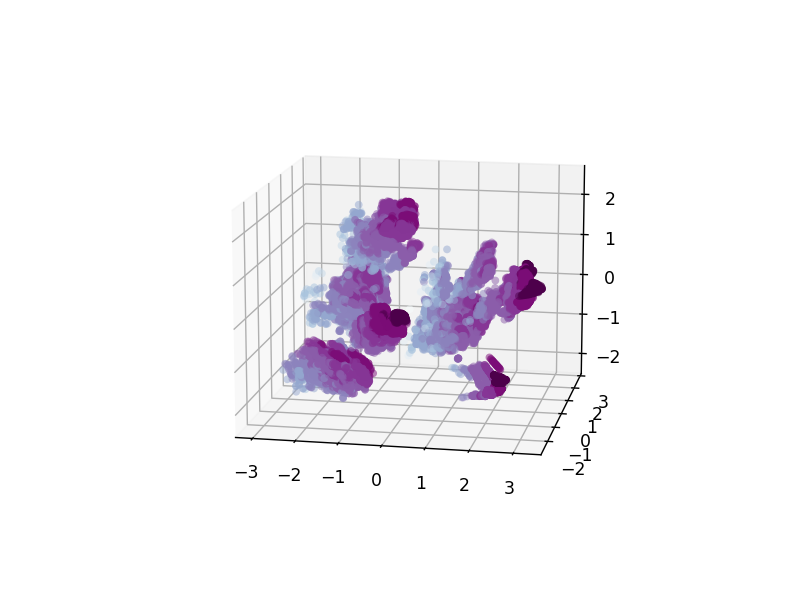

/tmp/ipykernel_209/4077645877.py:4: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  threedee = plt.figure().gca(projection='3d')


In [70]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])
#plt.figure(figsize=(20,10)) 
threedee = plt.figure().gca(projection='3d')

threedee.scatter(principalDf['principal component 1'],principalDf['principal component 2'], principalDf['principal component 3'],c=df['Eat'], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('BuPu', 10))
plt.show()

In [ ]:
model.parameters()

In [ ]:

vec=df['DIP']
principalDf.plot.scatter('principal component 1','principal component 2',c=vec, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('BuPu', 10))

In [ ]:
vec=df['#O']+df['#N']
principalDf.plot.scatter('principal component 1','principal component 2',c=vec, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('BuPu', 10))

<IPython.core.display.Javascript object>


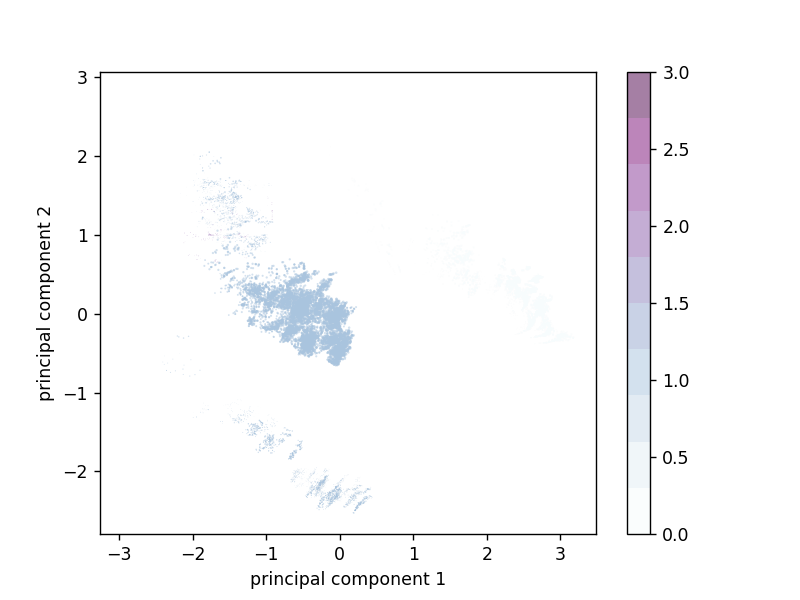

/home/roxasfall/.local/lib/python3.8/site-packages/matplotlib/collections.py:1003: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


<AxesSubplot:xlabel='principal component 1', ylabel='principal component 2'>

In [62]:
principalDf.plot.scatter('principal component 1','principal component 2','principal component 3',c=df['#O'], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('BuPu', 10))

In [ ]:
#a=np.random.uniform(-1,1,size=(4))
vector=list(np.multiply(df['#O'],df['#N'])+np.multiply(df['#C'],df['#O']))#+
#vec2=list(np.multiply(df['#O'],df['#C']))
#vector=vector+vec2#[a*b for a,b in zip(df['Eat'],df['POL'])]#a[0]*df['Eat']+a[1]*df['HLGAP']+a[2]*df['C6']+a[3]*df['POL']+df['EMBD']
principalDf.plot.scatter('principal component 1','principal component 2',c=vector, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('BuPu', 10))
print(a)

In [ ]:
list(np.multiply([1,2,3],[1,1,1]))

In [ ]:

properties=df.loc[:, df.columns != 'BoB']
properties=properties[properties.columns[:7]]
props=torch.Tensor(properties.values[0:30000,:])
#dfnew
labels= torch.Tensor(dfnew.values[0:30000,:])


In [ ]:
dataset = TensorDataset(props,labels)

In [ ]:
model2 = nn.Sequential(
          nn.Linear(7,50),
          nn.Tanh(),
          nn.BatchNorm1d(num_features=50),
          nn.Linear(50,50),
          nn.Tanh(),
          nn.BatchNorm1d(num_features=50),
          nn.Linear(50,40),
        )


In [ ]:
epochs=200
batch_size=25
train_size=20000
learning_rate=1e-3
#df=df.sample(frac=1)

#print(dati.size(),labels.size())
#dati_test2=df3[40000:43130]
#labels_test2=labels[40000:43130,:]
#dataset = TensorDataset(dati,labels)
def perc_error(a,b):
    numer=torch.sum((a-b).abs(),dim=1)
    denom=torch.sum(b.abs(),dim=1)
    num2=(a-b).abs()
    den2=b.abs()
    
    return 100*torch.mean(numer/denom)#,100*torch.mean(torch.mean(num2/den2,1))

def randomize_rowise(tensor):
    a=tensor
    for i in range (0,tensor.size()[0]):
        a[i,:]=a[i,torch.randperm(a.size()[1])]
    return a

trainset,testset=split(dataset,train=train_size,test=30000-train_size)
test_dataloader = DataLoader(testset, batch_size=30000-train_size, shuffle=False)
test_batch,test_lbs=next(iter(test_dataloader))
optimizer = optim.AdamW(model2.parameters(), lr=learning_rate)
scheduler= ReduceLROnPlateau(optimizer, 'min',factor=.9,patience=2)
loss_tr_reco=torch.Tensor([0.0])


In [ ]:
test_lbs.size()

In [ ]:
plt.figure()
plt.scatter(df['C6'],df['EMBD'])

In [ ]:
model2.apply(reset_weights)
#model.train()

e=0
while optimizer.param_groups[0]['lr']>1e-6:

    train_dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    for i in range(0,int(train_size/batch_size)):
        model2.train()
        train_ft,train_lb=next(iter(train_dataloader))
        #model.train()
        mu_logvar=model2(train_ft)
        #print(mu_logvar.size())
        mu_x=mu_logvar[:,0:20]
        logvar=mu_logvar[:,20:40]
        loss_tr_reco=-reconstruction(mu_x,train_lb,logvar)
        optimizer.zero_grad()
        loss=loss_tr_reco
        loss.backward()
        optimizer.step()
        
    if e%(5)==0:
        model2.eval()
        with torch.no_grad():
            mu_logvar=model2(test_batch)#=model(test_batch)#
            mu_x=mu_logvar[:,0:20]
            logvar=mu_logvar[:,20:40]
            loss_tst_reco=-reconstruction(mu_x,test_lbs,logvar)
            loss_tst=loss_tst_reco#1e4*loss_tst_prop+
            print('reco',e,i,loss.item(),loss_tst.item(),optimizer.param_groups[0]['lr'])
            scheduler.step(loss_tst)
    e=e+1

    


In [ ]:
#model and loss

input_dim=len(df['BoB'][0])
latent_size=len(df.columns)
beta=1
alpha=1

class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder=nn.Sequential(
            nn.Linear(input_dim,latent_size*6),
            nn.Tanh(),
            nn.Linear(latent_size*6,latent_size*2)
        )
        
        self.decoder=nn.Sequential(
            nn.Linear(latent_size,latent_size*4),
            nn.Tanh(),
            nn.Linear(latent_size*4,latent_size*8),
            nn.Tanh(),
            nn.Linear(latent_size*8,input_dim),
            
        )
        
        self.mu_prop_pred=nn.Sequential(
            nn.Linear(latent_size,latent_size)
        )
                 
        
        
        
    def reparameterize(self,mu,logvar):
        if self.training:
            std=logvar.mul(0.5).exp()
            eps=std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    def encode(self, x):
        
        mu_logvar=self.encoder(x.view(-1,input_dim)).view(-1,2,latent_size)
        mu=mu_logvar[:,0,:]
        logvar=mu_logvar[:,1,:]
        return mu, logvar
    
    def decode(self,z):
        mu_logvar=self.decoder(z).view(-1,2,input_dim)
        mu=mu_logvar[:,0,:]
        logvar=mu_logvar[:,1,:]
        return mu, logvar
    
    def predict(self,mu):
        mup=self.mu_prop_pred(mu)
        logvarp=self.logvar_prop_pred(mu)
        return mup,logvarp
            
    def forward(self,x):
        mu,logvar=self.encode(x)
        z=self.reparameterize(mu,logvar)
        mup,logvarp=self.predict(mu)
        mu_x=self.decode(z)
        return mu_x,mu,logvar,z,mup,logvarp
    
    def sample(self, n_samples):
        z=torch.randn((n_samples,latent_size))
        return self.decode(z)
    
#def reconstruction(x,mu,logvar):
#    logscale=nn.Parameter(logvar)
#    scale=logscale.mul(0.5).exp()
#    dist=torch.distributions.Normal(mu,scale)
#    log_pxz=dist.log_prob(x)
#    reco=log_pxz.sum(-1)
#    return reco.mean()
    
def kl_divergence(z, mu, logvar):
    std = logvar.mul(0.5).exp()
    kl=0.5*torch.sum(logvar.exp()+mu.pow(2)-torch.ones_like(mu)-logvar,dim=1)
    return kl.mean()
    
def ELBO_beta(x,z,mu,logvar,mu_x,logvar_x,beta):
    return beta*kl_divergence(z=z,mu=mu,logvar=logvar)-reconstruction(x,mu_x,logvar_x)



In [ ]:
a=torch.ones_like(train_ft)
a.size()
train_ft

In [ ]:
torch.randn(a.size())

In [ ]:
VAE().reparameterize(torch.Tensor([0.0]),torch.Tensor([1.0,1.0,1.0]),10)

In [ ]:
print(a)
b=a
print(randomize_rowise(b))

In [ ]:
df=df2
df['Eat']=df['Eat'].apply(lambda x: x/(df['Eat'].abs()).max())
df['EMBD']=df['EMBD'].apply(lambda x: x/(df['EMBD'].abs()).max())
df['EPBE0']=df['EPBE0'].apply(lambda x: x/(df['EPBE0'].abs()).max())
df['C6']=df['C6'].apply(lambda x: x/(df['C6'].abs()).max())
df['POL']=df['POL'].apply(lambda x: x/(df['POL'].abs()).max())
df['HLGAP']=df['HLGAP'].apply(lambda x: x/(df['HLGAP'].abs()).max())
df['DIP']=df['DIP'].apply(lambda x: x/(df['DIP'].abs()).max())


In [ ]:
df

In [ ]:
rep2=generate_bob(atom,pos,size=14,asize={'C': 4, 'H': 7, 'N': 1, 'O': 0, 'S': 1,'Cl':0})
print(rep2)

In [ ]:
atoms,properties=data.get_properties(99)
view(atoms,viewer='x3d')

In [ ]:
print(rep-rep2)

In [ ]:
file=h5py.File('8000.hdf5','r')
file['7001'].keys()

In [ ]:
file[10][]

In [ ]:
data.__len__()

In [ ]:
data[0]['_positions'].size()==torch.Size([1])


In [ ]:
def get_isomers(data,at_numbers): #inputs are AtomsData dataset and the atomic number tensor
    indices=[]                    #buffer for the indices of isomers
    for i in range(0,data.__len__()): #checks for every atom if there is tensor equivalence (same size and elements)
        if torch.equal(at_numbers,data[i]['_atomic_numbers']):
            indices.append(i)
    return np.array(indices) #save and return array of indices

            
        

In [ ]:
at_numbers=data[100]['_atomic_numbers'] #choose one molecule and get atomic number tensor
ind=get_isomers(data,at_numbers) #get the indices array of isomers
isomers=data.create_subset(ind) #create subset with that array of indices
print(isomers.__len__()) #check that the result makes sense

In [ ]:
def get_property_array(data,prop):
    if data[0][prop].size()!=torch.Size([1]):
        print('only 1-dimensional properties please')
        exit()
    else:
        tmp=[]
        for i in range(0,data.__len__()):
            tmp.append(data[i][prop].item())
    return np.array(tmp)
    

In [ ]:
Eats_isos=get_property_array(isomers,'EPBE0')
plt.hist(Eats_isos)

In [ ]:
plt.hist(Eats_isos)

In [ ]:
Dip=get_property_array(data,'DIP')

In [ ]:
plt.hist(Dip,bins=1000)

In [ ]:
a=np.array([1,0,0,1])
b=np.array([0,1,0,1])
c=a<b
